In [1]:
from pathlib import Path
import numpy as np
import supervision as sv
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
PATH_VID = Path("./material/focus_video.mov")

COLORS = (
    'blue','red','orange','green', 'brown', 
    'purple', 'teal', 'crimson', 'darkolivegreen', 'magenta')

# Parte 1: _Image Sharpness Measure for Blurred Images in Frequency Domain_

In [3]:
def metric_ismfd(img: np.ndarray) -> float:
    """Calculates the Image Sharpness Measure in Frequency Domain metric for a given image.

    Args:
        img (np.ndarray): Grayscale image of shape (m,n).

    Returns:
        float: Metric as calculated on the image.
    """

    # Following paper line-by-line
    f = np.fft.fft2(img)
    fc = np.fft.fftshift(f)
    af = np.abs(fc)
    m = af.max().item()

    th = np.sum(f > (m/1000))

    return th / img.size 

In [4]:
# info sobre el video
sv.VideoInfo.from_video_path(PATH_VID)

VideoInfo(width=640, height=360, fps=29, total_frames=171)

In [5]:
# helper
def grayscale_float_frames():
    for frame in sv.get_video_frames_generator(source_path=PATH_VID):
        x = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        x = x.astype(float)

        yield x

In [6]:
METRICS = dict()

## a) Midiendo sobre todo el frame

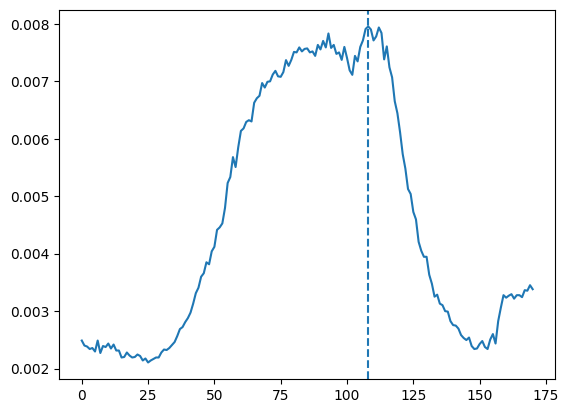

In [7]:
ism_whole_frame = np.array([metric_ismfd(img) for img in grayscale_float_frames()])

METRICS['ism_whole_frame'] = ism_whole_frame

plt.plot(ism_whole_frame)
lims = plt.ylim()
plt.vlines(ism_whole_frame.argmax(), *lims, linestyle='dashed')
plt.ylim(*lims)
plt.show()

Se observa un correcto aumento de la métrica bien alineado con el intervalo de tiempo en que la cámara hace foco en el video.

## b) Sobre ROI centrada

In [8]:
def get_center_roi(img: np.ndarray, area_fraction: float) -> np.ndarray:
    """Return the centered region of the image, determined by fraction of total area.
    Approximately preserves aspect ratio.

    Args:
        img (np.ndarray): Grayscale image of shape (m,n).
        area_fraction (float): Fraction of total area between 0 and 1.

    Returns:
        np.ndarray: Masked array.
    """
    h, w = img.shape
    frac = 0.5*np.sqrt(area_fraction)

    return img[
        int(h//2 - h*frac):int(h//2 + h*frac), 
        int(w//2 - w*frac):int(w//2 + w*frac)
    ]

In [9]:
for area_frac in (0.05, 0.1):
    METRICS[f"ism_roi_{area_frac}"] = np.array([
        metric_ismfd(get_center_roi(img, area_frac)) 
        for img in grayscale_float_frames()
    ])

[ism_whole_frame] max at frame 108
[   ism_roi_0.05] max at frame 111
[    ism_roi_0.1] max at frame 111


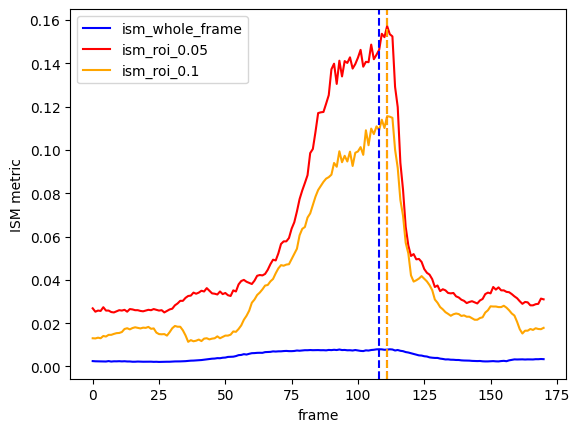

In [10]:
for (name, historic), color in zip(METRICS.items(),COLORS):
    plt.plot(historic, label=name, color=color)
    
lims = plt.ylim()
for (name, historic), color in zip(METRICS.items(),COLORS):
    argmax = historic.argmax()
    print(f"[{name: >15}] max at frame {argmax}")
    plt.vlines(argmax, *lims, linestyle='dashed',color=color)
plt.ylim(*lims)

plt.xlabel('frame')
plt.ylabel('ISM metric')
plt.legend(loc='upper left')
plt.show()

* Comparativamente con la métrica sobre todo el frame, las de ROI tienen un rango mucho mayor
* El máximo se encuentra muy cercano en todos los casos (108, 111, 111)
* El máximo coincide para ambos valores de área de ROI considerados
* En este gráfico no se aprecia, pero en el anterior se puede observar que la zona de enfoque del caso de frame completo está bien diferenciada.

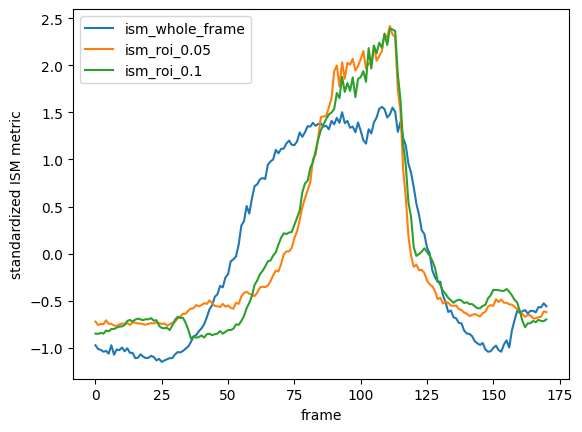

In [11]:
# extra: estandarización de las métricas para que tengan el mismo rango aprox.

for name, historic in METRICS.items():
    plt.plot((historic-historic.mean())/historic.std(), label=name)

plt.xlabel('frame')
plt.ylabel('standardized ISM metric')
plt.legend(loc='upper left')
plt.show()

Aplicada una estandarización, se observa que:

* La región considerada por el método a frame completo es bastante mayor y más "simétrica"
* Ambas fracciones de ROI son casi equivalentes en la zona de enfoque

# Parte 2: _Analysis of focus measure operators in shape-from-focus_

En el paper se menciona que los métodos de la familia del Laplaciano son los que mejor performan bajo condiciones normales. Los rankings sobre las tres familias de datos utilizados resaltan que los métodos $LAP2$ y $WAV1$ son muy buenos. El paper menciona que los basados en wavelet sufren menor deterioro en performance cuando se disminuye el _window size_ que los basados en el laplaciano. Por otra parte, $LAP2$ es casi un orden de magnitud más rápido que $WAV1$.

En base a estos datos, se seleccionó el método $LAP2$.

In [12]:
def metric_lap2(img: np.ndarray) -> float:
    """Calculates the LAP2 metric for a given image.

    Args:
        img (np.ndarray): Grayscale image of shape (m,n).

    Returns:
        float: Metric as calculated on the image.
    """

    # following the paper
    lap_kernel = np.array([-1,2,-1], dtype=float).reshape(-1,1)

    lx = cv.filter2D(img, -1, lap_kernel)
    ly = cv.filter2D(img, -1, lap_kernel.T)

    # LAP2 is the sum of absolute values of lx and ly
    return np.abs(lx).sum() + np.abs(ly).sum()

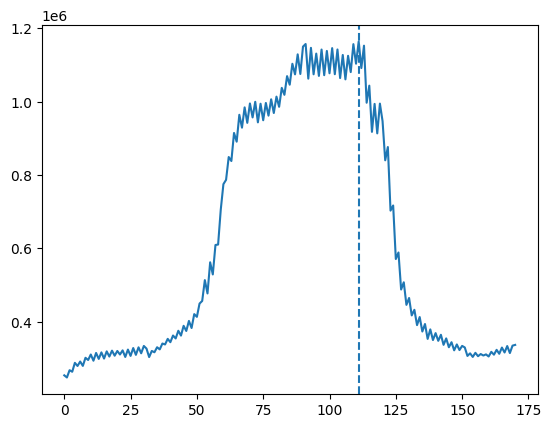

In [13]:
# se muestra uso
lap2_whole = np.array([metric_lap2(img) for img in grayscale_float_frames()])

METRICS['lap2_whole_frame'] = lap2_whole

plt.plot(lap2_whole)
lims = plt.ylim()
plt.vlines(lap2_whole.argmax(), *lims, linestyle='dashed')
plt.ylim(*lims)
plt.show()

In [14]:
for area_frac in (0.05, 0.1):
    METRICS[f"lap2_roi_{area_frac}"] = np.array([
        metric_lap2(get_center_roi(img, area_frac)) 
        for img in grayscale_float_frames()
    ])

[  lap2_whole_frame] max at frame 111
[     lap2_roi_0.05] max at frame 97
[      lap2_roi_0.1] max at frame 111


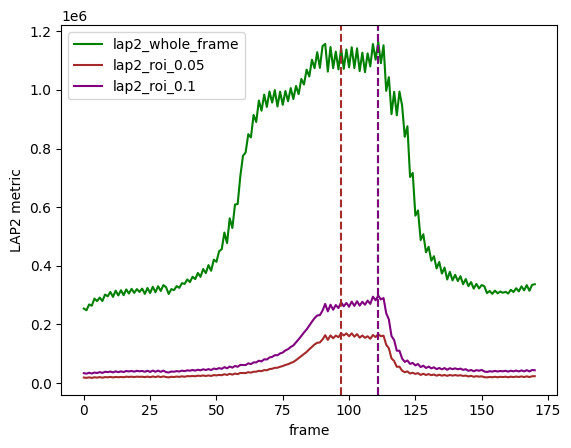

In [15]:
# ploteamos todos los LAP2 juntos
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not name.startswith('lap2'): continue
    plt.plot(historic, label=name, color=color)
    
lims = plt.ylim()
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not name.startswith('lap2'): continue
    argmax = historic.argmax()
    print(f"[{name: >18}] max at frame {argmax}")
    plt.vlines(argmax, *lims, linestyle='dashed',color=color)
plt.ylim(*lims)

plt.xlabel('frame')
plt.ylabel('LAP2 metric')
plt.legend(loc='upper left')
plt.show()

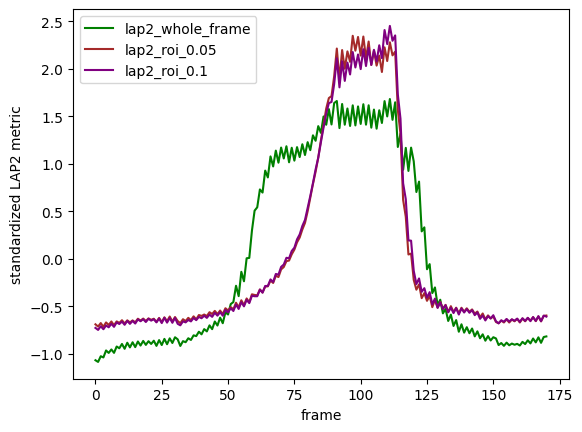

In [16]:
# volvemos a estandarizar para comparar curvas
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not name.startswith('lap2'): continue
    plt.plot((historic-historic.mean())/historic.std(), label=name, color=color)
    

plt.xlabel('frame')
plt.ylabel('standardized LAP2 metric')
plt.legend(loc='upper left')
plt.show()

* El orden de magnitud de los valores es mucho mayor, especialmente en el caso de frame completo
* En dos casos el máximo es idéntico al del método anterior con ROI, para ROI chico es un poco distinto, acorde a lo antes mencionado en el paper.
* La forma de las curvas es similar al caso anterior: bastante asimétrico para ROI, más simétrico para frame completo.


En el paper y en la teoría en general se menciona que el Laplaciano es muy susceptible a ruido, se muestra utilización de suavizado gaussiano simple previo.

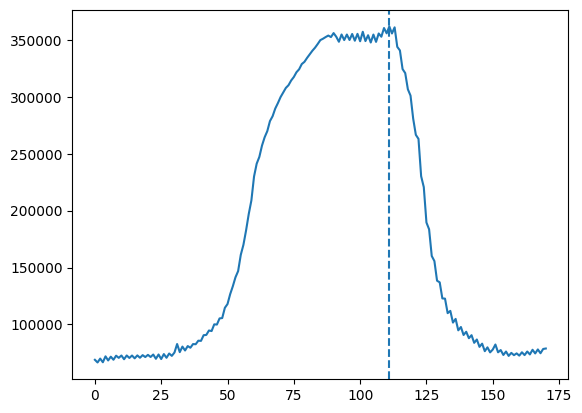

In [17]:
# con gaussian blur previo
lap2_whole_blurred = np.array([
    metric_lap2(cv.GaussianBlur(img, (5, 5), 1)) 
    for img in grayscale_float_frames()
])

plt.plot(lap2_whole_blurred)
lims = plt.ylim()
plt.vlines(lap2_whole_blurred.argmax(), *lims, linestyle='dashed')
plt.ylim(*lims)
plt.show()

El ruido se redujo mucho, aunque el máximo sigue en el mismo lugar.

In [18]:
METRICS['lap2_whole_blurred'] = lap2_whole_blurred

In [19]:
# replicamos para los ROI
# el blur lo aplicamos al ROI directamente

for area_frac in (0.05, 0.1):
    METRICS[f"lap2_roi_{area_frac}_blurred"] = np.array([
        metric_lap2(cv.GaussianBlur(get_center_roi(img, area_frac), (5, 5), 1)) 
        for img in grayscale_float_frames()
    ])

[lap2_whole_blurred] max at frame 111
[lap2_roi_0.05_blurred] max at frame 112
[lap2_roi_0.1_blurred] max at frame 112


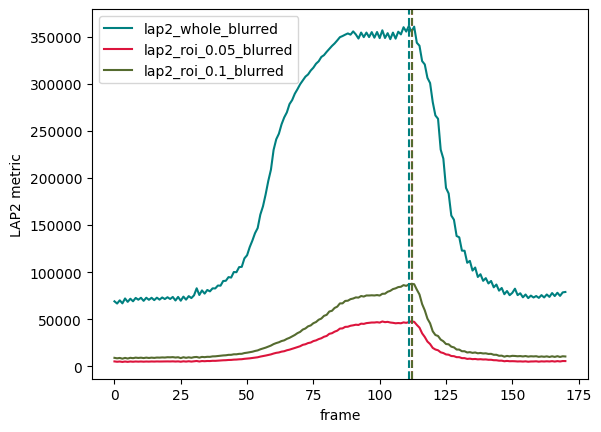

In [20]:
# volvemos a plotear, solo LAP2+blur
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not (name.startswith('lap2') and name.endswith('blurred')): continue
    plt.plot(historic, label=name, color=color)
    
lims = plt.ylim()
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not (name.startswith('lap2') and name.endswith('blurred')): continue
    argmax = historic.argmax()
    print(f"[{name: >18}] max at frame {argmax}")
    plt.vlines(argmax, *lims, linestyle='dashed',color=color)
plt.ylim(*lims)

plt.xlabel('frame')
plt.ylabel('LAP2 metric')
plt.legend(loc='upper left')
plt.show()

* El ROI 0.05 que antes detectaba un máximo diferente (por ruido) ahora es consistente con los demás
* Las curvas son mucho más suaves, sin detrimento de la detección de frame de máximo enfoque
* Ahora el frame de máximo enfoque detectado es el 112 en vez del 111, incluso si se considera un error, es despreciable.

# Extra 1: Matriz de enfoque

In [21]:
GRIDS = [(x,y) for x in (3,5,7) for y in (3,5,7)]

GRIDS

[(3, 3), (3, 5), (3, 7), (5, 3), (5, 5), (5, 7), (7, 3), (7, 5), (7, 7)]

In [22]:
def get_roi_rectangle(img: np.ndarray, row_start: int, row_end: int, col_start: int, col_end: int) -> np.ndarray:
    """Extrae una ROI rectangular usando coordenadas específicas de filas y columnas.
    
    Args:
        img (np.ndarray): Imagen en escala de grises de forma (h, w).
        row_start (int): Fila inicial (coordenada Y superior).
        row_end (int): Fila final (coordenada Y inferior).
        col_start (int): Columna inicial (coordenada X izquierda).
        col_end (int): Columna final (coordenada X derecha).
        
    Returns:
        np.ndarray: ROI extraída.
    """
    h, w = img.shape
    
    # Validar y ajustar coordenadas para que estén dentro de los límites
    row_start = max(0, min(row_start, h))
    row_end = max(row_start, min(row_end, h))
    col_start = max(0, min(col_start, w))
    col_end = max(col_start, min(col_end, w))
    
    return img[row_start:row_end, col_start:col_end]


def get_all_grid_rois(img: np.ndarray, grid_size: tuple, spacing_fraction: float = 0.01) -> np.ndarray:
    """Extract all ROIs from an NxM grid subdivision of the image with spacing between cells.
    
    Args:
        img (np.ndarray): Grayscale image of shape (h, w).
        grid_rows (int): Number of rows in the grid (N).
        grid_cols (int): Number of columns in the grid (M).
        spacing_fraction (float): Fraction of image size to use as spacing between cells.
                                 For example, 0.01 = 1% of image size as spacing.
        
    Returns:
        np.ndarray: Array of shape (grid_rows, grid_cols) containing the ROIs.
                   Each element is a 2D array representing one grid cell.
    """
    h, w = img.shape
    grid_rows, grid_cols = grid_size
    rois = np.empty((grid_rows, grid_cols), dtype=object)
    
    # Calculate spacing as fraction of image dimensions
    spacing_rows = int(h * spacing_fraction)
    spacing_cols = int(w * spacing_fraction)
    
    # Calculate total spacing needed
    total_spacing_rows = spacing_rows * (grid_rows - 1)
    total_spacing_cols = spacing_cols * (grid_cols - 1)
    
    # Calculate cell dimensions accounting for spacing
    cell_height = (h - total_spacing_rows) // grid_rows
    cell_width = (w - total_spacing_cols) // grid_cols
    
    for row in range(grid_rows):
        for col in range(grid_cols):
            # Calculate coordinates with spacing
            row_start = row * (cell_height + spacing_rows)
            row_end = row_start + cell_height
            col_start = col * (cell_width + spacing_cols)
            col_end = col_start + cell_width
            
            # Extract ROI using get_roi_rectangle
            rois[row, col] = get_roi_rectangle(img, row_start, row_end, col_start, col_end)
    
    return rois


def calculate_focus_matrix(img: np.ndarray, grid_size: tuple, focus_metric_func, spacing_fraction: float = 0.01) -> np.ndarray:
    """Calculate focus metrics for each cell in an NxM grid subdivision using square ROIs centered in the image.
    
    Args:
        img (np.ndarray): Grayscale image of shape (h, w).
        grid_size (tuple): Tuple (grid_rows, grid_cols) defining the grid dimensions.
        focus_metric_func: Function that takes an image and returns a focus metric.
        spacing_fraction (float): Fraction of image size to use as spacing between cells.
        
    Returns:
        np.ndarray: Matrix of shape (grid_rows, grid_cols) with focus metrics.
    """
    grid_rows, grid_cols = grid_size
    h, w = img.shape
    
    # Calculate spacing as fraction of image dimensions
    spacing_rows = int(h * spacing_fraction)
    spacing_cols = int(w * spacing_fraction)
    
    # Calculate total spacing needed
    total_spacing_rows = spacing_rows * (grid_rows - 1)
    total_spacing_cols = spacing_cols * (grid_cols - 1)
    
    # Calculate available space for cells
    available_height = h - total_spacing_rows
    available_width = w - total_spacing_cols
    
    # Calculate cell dimensions for rectangular grid
    cell_height = available_height // grid_rows
    cell_width = available_width // grid_cols
    
    # Force square ROIs by using the smaller dimension
    cell_size = min(cell_height, cell_width)
    
    # Calculate total grid dimensions
    total_grid_height = grid_rows * cell_height + total_spacing_rows
    total_grid_width = grid_cols * cell_width + total_spacing_cols
    
    # Center the entire grid within the image
    grid_start_row = (h - total_grid_height) // 2
    grid_start_col = (w - total_grid_width) // 2
    
    # Calculate focus matrix
    focus_matrix = np.zeros((grid_rows, grid_cols), dtype=float)
    
    for row in range(grid_rows):
        for col in range(grid_cols):
            # Calculate coordinates with spacing, offset by grid centering
            row_start = grid_start_row + row * (cell_height + spacing_rows)
            col_start = grid_start_col + col * (cell_width + spacing_cols)
            
            # Center the square ROI within the available cell space
            if cell_height > cell_size:
                row_offset = (cell_height - cell_size) // 2
                row_start += row_offset
            
            if cell_width > cell_size:
                col_offset = (cell_width - cell_size) // 2
                col_start += col_offset
            
            # Extract square ROI
            row_end = row_start + cell_size
            col_end = col_start + cell_size
            
            # Use get_roi_rectangle to extract the square ROI
            square_roi = get_roi_rectangle(img, row_start, row_end, col_start, col_end)
            
            # Calculate focus metric for this square ROI
            focus_matrix[row, col] = focus_metric_func(square_roi)
    
    return focus_matrix



In [23]:
# Obtener un frame específico
def get_frame_at_index(frame_index: int):
    """Obtiene un frame específico del video por su índice."""
    for i, frame in enumerate(grayscale_float_frames()):
        if i == frame_index:
            return frame
    return None

# un frame cualquiera para ver cómo funciona
img = get_frame_at_index(112)

# Calcular matrices de focos usando foreach con GRIDS
focus_matrices = {}

for grid_size in GRIDS:
    # LAP2
    focus_matrices[f'LAP2_{grid_size[0]}x{grid_size[1]}'] = calculate_focus_matrix(img, grid_size, metric_lap2, spacing_fraction=0.01)
    
    # ISMFD  
    focus_matrices[f'ISMFD_{grid_size[0]}x{grid_size[1]}'] = calculate_focus_matrix(img, grid_size, metric_ismfd, spacing_fraction=0.01)


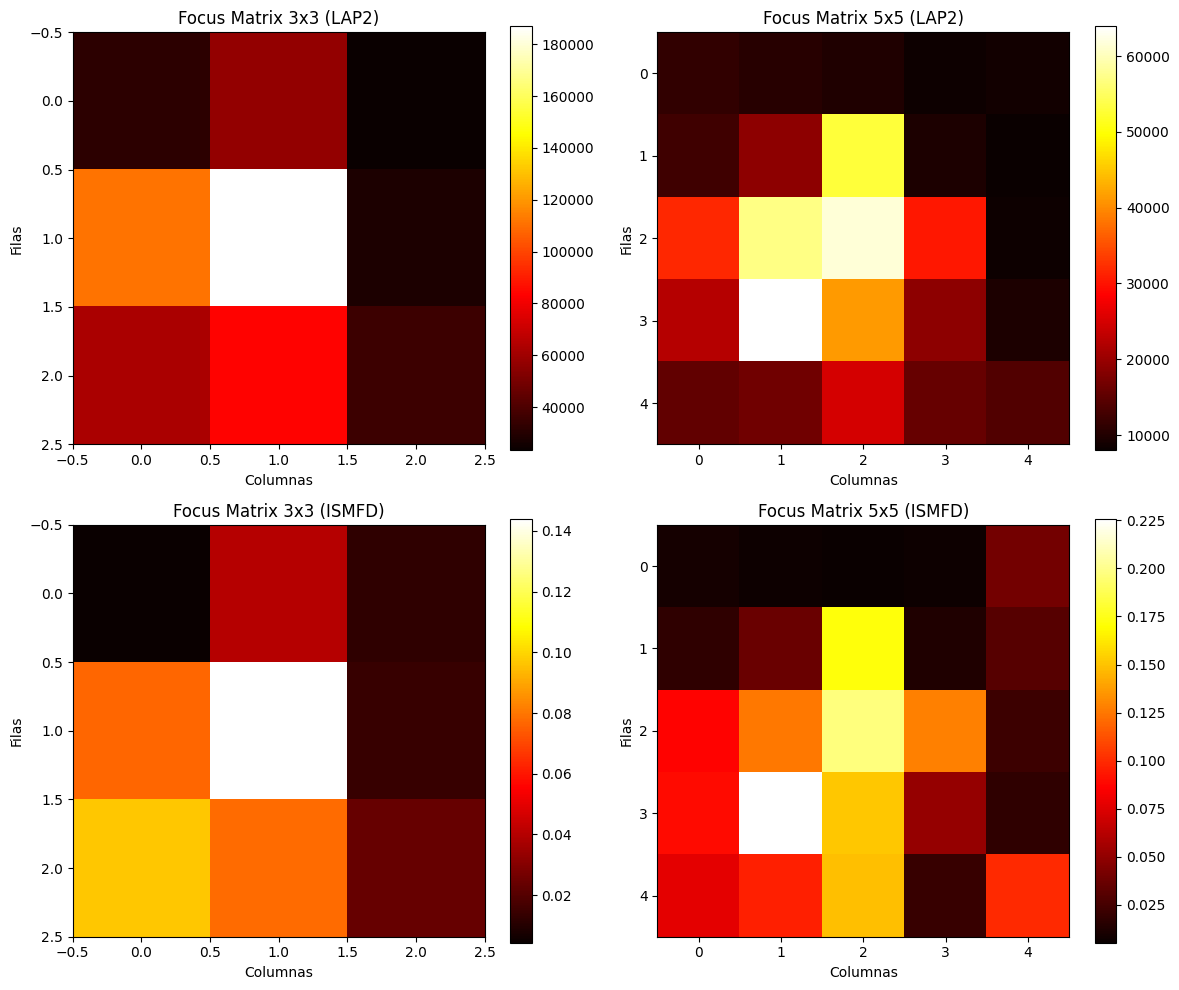

In [24]:
# Visualizar las matrices de focos específicas 
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# LAP2 3x3
im1 = axes[0,0].imshow(focus_matrices['LAP2_3x3'], cmap='hot', interpolation='nearest')
axes[0,0].set_title('Focus Matrix 3x3 (LAP2)')
axes[0,0].set_xlabel('Columnas')
axes[0,0].set_ylabel('Filas')
plt.colorbar(im1, ax=axes[0,0])

# LAP2 5x5
im2 = axes[0,1].imshow(focus_matrices['LAP2_5x5'], cmap='hot', interpolation='nearest')
axes[0,1].set_title('Focus Matrix 5x5 (LAP2)')
axes[0,1].set_xlabel('Columnas')
axes[0,1].set_ylabel('Filas')
plt.colorbar(im2, ax=axes[0,1])

# ISMFD 3x3
im3 = axes[1,0].imshow(focus_matrices['ISMFD_3x3'], cmap='hot', interpolation='nearest')
axes[1,0].set_title('Focus Matrix 3x3 (ISMFD)')
axes[1,0].set_xlabel('Columnas')
axes[1,0].set_ylabel('Filas')
plt.colorbar(im3, ax=axes[1,0])

# ISMFD 5x5
im4 = axes[1,1].imshow(focus_matrices['ISMFD_5x5'], cmap='hot', interpolation='nearest')
axes[1,1].set_title('Focus Matrix 5x5 (ISMFD)')
axes[1,1].set_xlabel('Columnas')
axes[1,1].set_ylabel('Filas')
plt.colorbar(im4, ax=axes[1,1])

plt.tight_layout()
plt.show()

Ahora vamos a ensayar con varias formas de "medir" la matriz de enfoque:
- Opción 1: *Suma total* de la matriz de enfoque 3x3 para cada frame usando ISMFD
- Opción 2: *Máximo valor* de la matriz de enfoque 5x7 para cada frame usando LAP2
- Opción 3: *Promedio* de la matriz de enfoque 7x7 para cada frame usando LAP2


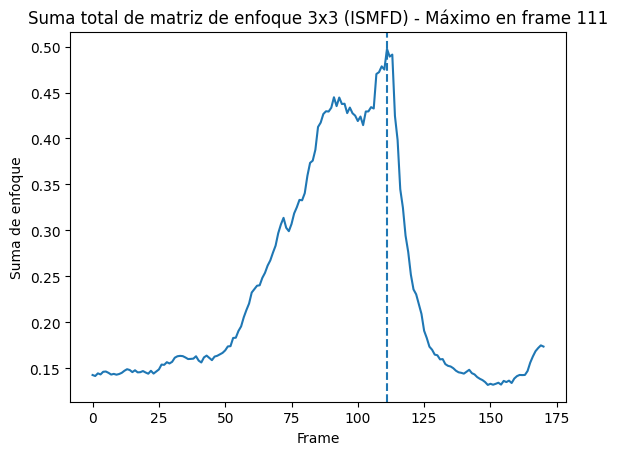

Máximo enfoque (suma total 3x3) usando ISMFD en frame: 111


In [25]:
# Opción 1: Suma total de la matriz de enfoque 3x3 para cada frame
focus_matrix_3x3_total = np.array([
    calculate_focus_matrix(img, (3, 3), metric_ismfd, spacing_fraction=0.01).sum() 
    for img in grayscale_float_frames()
])

METRICS['focus_matrix_3x3_total'] = focus_matrix_3x3_total

plt.plot(focus_matrix_3x3_total)
lims = plt.ylim()
max_frame_total = focus_matrix_3x3_total.argmax()
plt.vlines(max_frame_total, *lims, linestyle='dashed')
plt.ylim(*lims)
plt.title(f'Suma total de matriz de enfoque 3x3 (ISMFD) - Máximo en frame {max_frame_total}')
plt.xlabel('Frame')
plt.ylabel('Suma de enfoque')
plt.show()
print(f"Máximo enfoque (suma total 3x3) usando ISMFD en frame: {max_frame_total}")

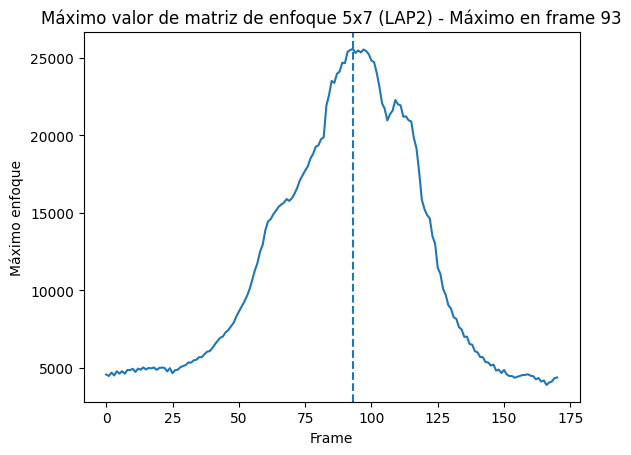

Máximo enfoque (valor máximo 5x7) usando LAP2 en frame: 93


In [26]:
# Opción 2: Máximo valor de la matriz de enfoque 5x7 para cada frame
focus_matrix_5x7_max = np.array([
    calculate_focus_matrix(cv.GaussianBlur(img, (5, 5), 1), (5, 7), metric_lap2, spacing_fraction=0.01).max() 
    for img in grayscale_float_frames()
])

METRICS['focus_matrix_5x7_max'] = focus_matrix_5x7_max

plt.plot(focus_matrix_5x7_max)
lims = plt.ylim()
max_frame_max = focus_matrix_5x7_max.argmax()
plt.vlines(max_frame_max, *lims, linestyle='dashed')
plt.ylim(*lims)
plt.title(f'Máximo valor de matriz de enfoque 5x7 (LAP2) - Máximo en frame {max_frame_max}')
plt.xlabel('Frame')
plt.ylabel('Máximo enfoque')
plt.show()
print(f"Máximo enfoque (valor máximo 5x7) usando LAP2 en frame: {max_frame_max}")

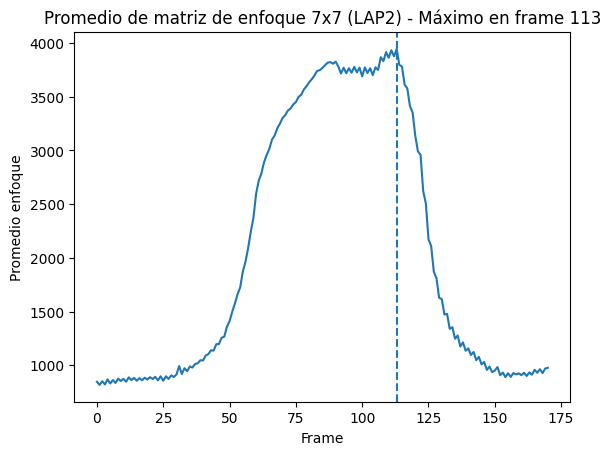

Máximo enfoque (promedio 7x7) usando LAP2 en frame: 113


In [27]:
focus_matrix_7x7_mean = np.array([
    calculate_focus_matrix(cv.GaussianBlur(img, (5, 5), 1), (7, 7), metric_lap2, spacing_fraction=0.01).mean() 
    for img in grayscale_float_frames()
])

METRICS['focus_matrix_7x7_mean'] = focus_matrix_7x7_mean

plt.plot(focus_matrix_7x7_mean)
lims = plt.ylim()
max_frame_mean = focus_matrix_7x7_mean.argmax()
plt.vlines(max_frame_mean, *lims, linestyle='dashed')
plt.ylim(*lims)
plt.title(f'Promedio de matriz de enfoque 7x7 (LAP2) - Máximo en frame {max_frame_mean}')
plt.xlabel('Frame')
plt.ylabel('Promedio enfoque')
plt.show()
print(f"Máximo enfoque (promedio 7x7) usando LAP2 en frame: {max_frame_mean}")

Otro método del paper 

In [28]:
def metric_tenengrad(img: np.ndarray) -> float:
    """Calculates the Tenengrad variance (GRA7) metric for a given image.
    
    This operator uses the variance of the image gradient as a focus measure.
    It was originally used for autofocus but can also be applied to SFF.
    
    Args:
        img (np.ndarray): Grayscale image of shape (m,n).
        
    Returns:
        float: Tenengrad metric as calculated on the image.
    """
    
    # Sobel operators for gradient calculation
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)
    
    # Calculate gradients in x and y directions
    gx = cv.filter2D(img, -1, sobel_x)
    gy = cv.filter2D(img, -1, sobel_y)
    
    # Calculate gradient magnitude: G = sqrt(Gx^2 + Gy^2)
    gradient_magnitude = np.sqrt(gx**2 + gy**2)
    
    # Calculate mean of gradient magnitude
    g_mean = np.mean(gradient_magnitude)
    
    # Calculate Tenengrad: sum of (G(i,j) - G_mean)^2
    tenengrad = np.sum((gradient_magnitude - g_mean)**2)
    
    return tenengrad

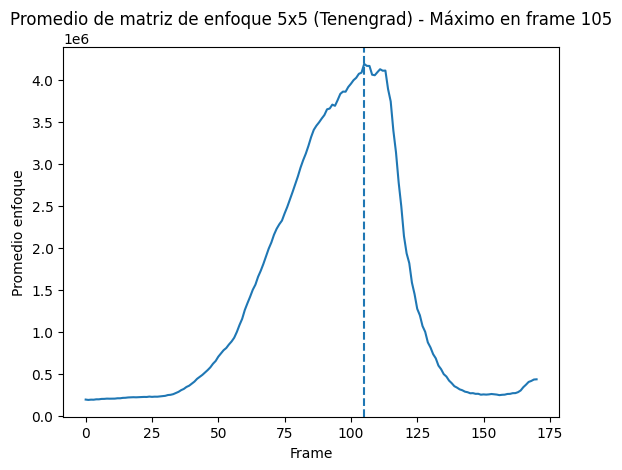

Máximo enfoque (promedio 5x5) usando Tenengrad en frame: 105


In [29]:
focus_matrix_5x5_mean = np.array([
    calculate_focus_matrix(cv.GaussianBlur(img, (5, 5), 1), (5, 5), metric_tenengrad, spacing_fraction=0.01).mean()
    for img in grayscale_float_frames()
])

METRICS['focus_matrix_5x5_mean'] = focus_matrix_5x5_mean

plt.plot(focus_matrix_5x5_mean)
lims = plt.ylim()
max_frame_mean = focus_matrix_5x5_mean.argmax()
plt.vlines(max_frame_mean, *lims, linestyle='dashed')
plt.ylim(*lims)
plt.title(f'Promedio de matriz de enfoque 5x5 (Tenengrad) - Máximo en frame {max_frame_mean}')
plt.xlabel('Frame')
plt.ylabel('Promedio enfoque')
plt.show()
print(f"Máximo enfoque (promedio 5x5) usando Tenengrad en frame: {max_frame_mean}")

# Extra 2: Unsharp Masking

In [30]:
def unsharp_masking(img: np.ndarray, k: float = 1.0, kernel_size: int = 5, sigma: float = 1.0) -> np.ndarray:
    """Implementa el filtro Unsharp Masking según la teoría proporcionada.
    
    Pasos:
    1. Desenfoque de la imagen con filtro suavizador (ej. Gaussiano): f(x,y) -> fB(x,y)
    2. Resta de la imagen original con la suavizada: m(x,y) = f(x,y) - fB(x,y)
    3. Agregar esa máscara a la imagen original: g(x,y) = f(x,y) + k·m(x,y)
    
    Fórmula genérica: g(x,y) = (k + 1)·f(x,y) - k·fB(x,y)
    
    Args:
        img (np.ndarray): Imagen original en escala de grises.
        k (float): Factor de intensidad del filtro.
                  k = 1: Máscara de desenfoque (unsharp masking)
                  k > 1: Filtrado de alto impulso (highboost filtering)
        kernel_size (int): Tamaño del kernel gaussiano (debe ser impar).
        sigma (float): Desviación estándar del filtro gaussiano.
        
    Returns:
        np.ndarray: Imagen procesada con unsharp masking.
    """
    
    # Desenfoque de la imagen con filtro gaussiano
    # f(x,y) -> fB(x,y)
    img_blurred = cv.GaussianBlur(img, (kernel_size, kernel_size), sigma)
    
    # Usando la fórmula genérica:
    img_sharpened = (k + 1) * img - k * img_blurred
    
    # Asegurar que los valores estén en el rango válido
    img_sharpened = np.clip(img_sharpened, 0, img.max())
    
    return img_sharpened

In [31]:
# Calcular métrica de enfoque para todos los frames
focus_matrix_3x3_total = np.array([
    calculate_focus_matrix(img, (3, 3), metric_ismfd, spacing_fraction=0.01).sum() 
    for img in grayscale_float_frames()
])

METRICS['focus_matrix_3x3_total'] = focus_matrix_3x3_total

# Encontrar máximo y calcular umbrales
max_focus_value = focus_matrix_3x3_total.max()
max_frame_total = focus_matrix_3x3_total.argmax()

# Definir umbrales como porcentajes del máximo
lower_threshold_pct = 70  # 80%
upper_threshold_pct = 90  # 90%

lower_threshold = max_focus_value * (lower_threshold_pct / 100)
upper_threshold = max_focus_value * (upper_threshold_pct / 100)

# Encontrar frames que están entre los umbrales
frames_in_range = np.where((focus_matrix_3x3_total >= lower_threshold) & 
                          (focus_matrix_3x3_total <= upper_threshold))[0]

print(f"Máximo enfoque (suma total 3x3) usando ISMFD en frame: {max_frame_total}")
print(f"Valor máximo de enfoque: {max_focus_value:.6f}")
print(f"Umbral inferior ({lower_threshold_pct}%): {lower_threshold:.6f}")
print(f"Umbral superior ({upper_threshold_pct}%): {upper_threshold:.6f}")
print(f"Total de frames en rango: {len(frames_in_range)}")

Máximo enfoque (suma total 3x3) usando ISMFD en frame: 111
Valor máximo de enfoque: 0.497415
Umbral inferior (70%): 0.348190
Umbral superior (90%): 0.447673
Total de frames en rango: 28


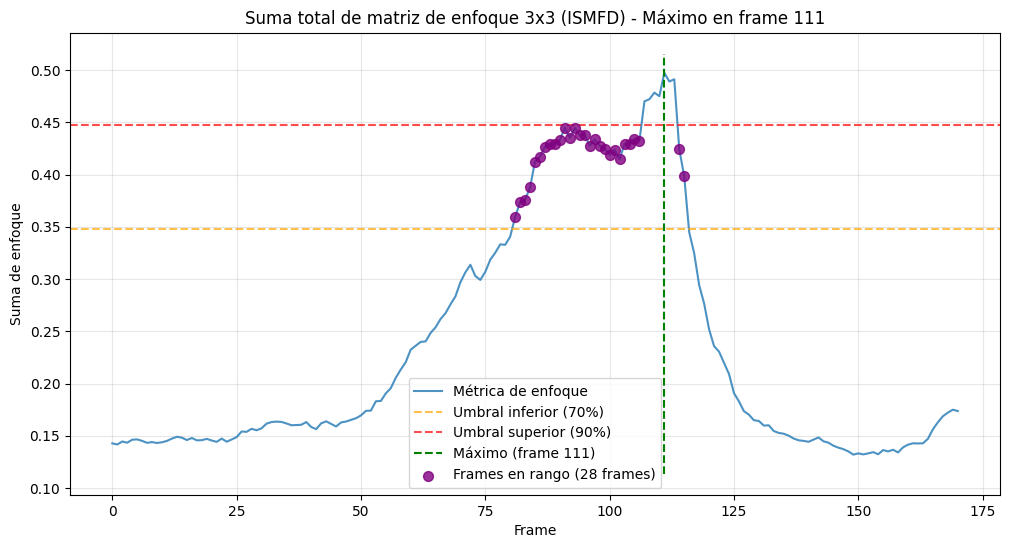

In [32]:
# Visualizar métricas con umbrales
plt.figure(figsize=(12, 6))
plt.plot(focus_matrix_3x3_total, label='Métrica de enfoque', alpha=0.8)

# Líneas de umbrales
plt.axhline(y=lower_threshold, color='orange', linestyle='--', alpha=0.7, 
           label=f'Umbral inferior ({lower_threshold_pct}%)')
plt.axhline(y=upper_threshold, color='red', linestyle='--', alpha=0.7, 
           label=f'Umbral superior ({upper_threshold_pct}%)')

# Línea de máximo
plt.vlines(max_frame_total, *plt.ylim(), linestyle='dashed', color='green', 
          label=f'Máximo (frame {max_frame_total})')

# Marcar frames en rango
if len(frames_in_range) > 0:
    plt.scatter(frames_in_range, focus_matrix_3x3_total[frames_in_range], 
               color='purple', s=50, alpha=0.8, zorder=5,
               label=f'Frames en rango ({len(frames_in_range)} frames)')

plt.title(f'Suma total de matriz de enfoque 3x3 (ISMFD) - Máximo en frame {max_frame_total}')
plt.xlabel('Frame')
plt.ylabel('Suma de enfoque')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
k_value = 0.3  # Valor de k para unsharp masking
kernel_size = 3  # Tamaño del kernel gaussiano
sigma = 1.0  # Desviación estándar del filtro gaussiano


# Aplicar unsharp masking a los frames en rango
if len(frames_in_range) > 0:
    focus_matrix_3x3_enhanced = focus_matrix_3x3_total.copy()
    for frame_idx in frames_in_range:
        original_frame = get_frame_at_index(frame_idx)
        enhanced_frame = unsharp_masking(original_frame, k_value, kernel_size, sigma)
        focus_matrix_3x3_enhanced[frame_idx] = calculate_focus_matrix(
            enhanced_frame, 
            (3, 3), 
            metric_ismfd, 
            spacing_fraction=0.01).sum()
    
    # Guardar en METRICS
    METRICS['focus_matrix_3x3_enhanced'] = focus_matrix_3x3_enhanced



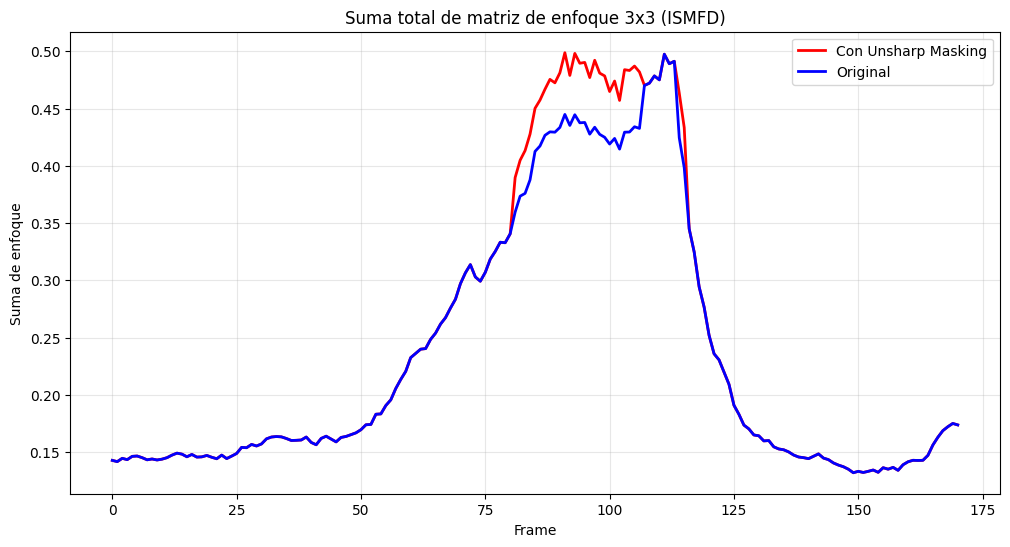

In [34]:
plt.figure(figsize=(12, 6))


# Curva con unsharp masking (roja) - solo si hay frames procesados
if len(frames_in_range) > 0:
    plt.plot(focus_matrix_3x3_enhanced, color='red', label='Con Unsharp Masking', linewidth=2)
    
# Curva original (azul)
plt.plot(focus_matrix_3x3_total, color='blue', label='Original', linewidth=2)

plt.title('Suma total de matriz de enfoque 3x3 (ISMFD)')
plt.xlabel('Frame')
plt.ylabel('Suma de enfoque')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
